In [1]:
#Imporing libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

np.random.seed(1234)
torch.manual_seed(1234)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# path to creative group
dl_path = '/content/drive/MyDrive/Fellowship.ai/Dockers_Outreach/Churn_Analysis/Deep_Learning/'

pd.set_option('display.max_columns', None)
df = pd.read_csv(dl_path+'marketing_data/data.csv', low_memory=False)

In [4]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB
None


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [5]:
# let's define churn as a customer who has not purchased in the last 6 months
df['churn'] = df.recency.apply(lambda x: 1 if (x > 6) else 0)
df['treatment'] = df.offer.apply(lambda x: 1 if x != 'No Offer' else 0)

df.treatment.describe()

count    64000.000000
mean         0.667094
std          0.471257
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: treatment, dtype: float64

In [6]:
def offer_conversion(df):
    if (df['offer'] != 'No Offer') & (df['conversion'] == 1):
        return 1
    else:
        return 0

def no_offer_conversion(df):
    if (df['offer'] == 'No Offer') & (df['conversion'] == 1):
        return 1
    else:
        return 0

In [7]:
#df['convert_with_offer'] = df.apply(offer_conversion, axis=1)
#df['convert_no_offer'] = df.apply(no_offer_conversion, axis=1)

In [8]:
df.describe(exclude='number').T

,count,unique,top,freq
zip_code,64000,3,Surburban,28776
channel,64000,3,Web,28217
offer,64000,3,Buy One Get One,21387


In [9]:
df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
recency,64000.0,5.763734,3.507592,1.00,2.00,6.00,9.0000,12.00
history,64000.0,242.085656,256.158608,29.99,64.66,158.11,325.6575,3345.93
used_discount,64000.0,0.551031,0.497393,0.00,0.00,1.00,1.0000,1.00
used_bogo,64000.0,0.549719,0.497526,0.00,0.00,1.00,1.0000,1.00
is_referral,64000.0,0.502250,0.499999,0.00,0.00,1.00,1.0000,1.00
conversion,64000.0,0.146781,0.353890,0.00,0.00,0.00,0.0000,1.00
churn,64000.0,0.428359,0.494845,0.00,0.00,0.00,1.0000,1.00
treatment,64000.0,0.667094,0.471257,0.00,0.00,1.00,1.0000,1.00


In [10]:
#Defining columns
categorical_columns = list(df.select_dtypes(exclude=['float', 'int']).columns.difference(['Churn']))
numerical_columns = list(df.columns.difference(categorical_columns))
outputs = ['churn']

In [11]:
train_records

NameError: ignored

In [12]:
#Processing columns

#Numerical
numerical_data = np.stack([df[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

#Categorical
for category in categorical_columns:
    df[category] = df[category].astype('category')
    
ch = df['channel'].cat.codes.values
off = df['offer'].cat.codes.values
zc = df['zip_code'].cat.codes.values

categorical_data = np.stack([ch, off, zc], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

#Outputs
df[outputs] = df[outputs].astype(int)

outputs = torch.tensor(df[outputs].values).flatten()
outputs = outputs.long()

In [14]:
#Dividing the data
total_records = numerical_data.shape[0]
train_records = int(total_records * .6)
valid_records = int(total_records * .2)
test_records = int(total_records * .2)
numerical_train_data = numerical_data[:train_records]
numerical_valid_data = numerical_data[train_records:train_records+valid_records]
numerical_test_data = numerical_data[train_records+valid_records:total_records]
categorical_train_data = categorical_data[:train_records]
categorical_valid_data = categorical_data[train_records:train_records+valid_records]
categorical_test_data = categorical_data[train_records+valid_records:total_records]
train_outputs = outputs[:train_records]
valid_outputs = outputs[train_records:train_records+valid_records]
test_outputs = outputs[train_records+valid_records:total_records]

In [15]:
from torch.nn.parameter import Parameter
from torch.nn import init
import math

#Creating the Neural Network
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(8, 100)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm1d(100)
        
        self.weights1 = Parameter(torch.Tensor(1, 112))
        init.kaiming_uniform_(self.weights1, a=math.sqrt(4))
        
        self.weights2 = Parameter(torch.Tensor(1, 112))
        init.kaiming_uniform_(self.weights2, a=math.sqrt(4))
        
        self.bias1 = Parameter(torch.Tensor(1))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weights1)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias1, -bound, bound)
        
        self.bias2 = Parameter(torch.Tensor(1))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weights2)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias2, -bound, bound)
        
        self.layer1_1 = nn.Embedding(3, 4)
        self.bn1_1 = nn.BatchNorm1d(4)
        self.layer1_2 = nn.Embedding(3, 4)
        self.bn1_2 = nn.BatchNorm1d(4)
        self.layer1_3 = nn.Embedding(3, 4)
        self.bn1_3 = nn.BatchNorm1d(4)
        
        self.layer2 = nn.Linear(112, 112)
        self.bn2 = nn.BatchNorm1d(112)
        
    def forward(self, x_numerical, x_categorical):
        x1 = self.layer1(x_numerical)
        x1 = self.relu(x1)
        x1 = self.bn1(x1)
        
        x1_embedding = self.layer1_1(x_categorical[:,0])
        x1_embedding = self.relu(x1_embedding)
        x1_embedding = self.bn1_1(x1_embedding)
        
        x2_embedding = self.layer1_2(x_categorical[:,1])
        x2_embedding = self.relu(x2_embedding)
        x2_embedding = self.bn1_2(x2_embedding)
        
        x3_embedding = self.layer1_3(x_categorical[:,2])
        x3_embedding = self.relu(x3_embedding)
        x3_embedding = self.bn1_3(x3_embedding)
        
        x_embedding = torch.cat([x1_embedding,x2_embedding,x3_embedding], 1)
                
        x1 = torch.cat([x1 , x_embedding], 1)
        
        x2 = self.layer2(x1)        
        emb = self.relu(x2)
        x2 = self.bn2(emb)
        
        x2_weights1 = torch.mm(x2, self.weights1.t()) + self.bias1
        x2_weights2 = torch.mm(x2, self.weights2.t()) + self.bias2
        
        x3 = torch.cat([x2_weights1, x2_weights2], 1)
                
        return emb, self.weights1, self.weights2, x3

In [16]:
model = Model()

In [17]:
churn_percentage = 0.4
model.load_state_dict(torch.load( dl_path+"model_train_cre_{}.pth".format(churn_percentage)))

<All keys matched successfully>

In [18]:
model.eval()
with torch.no_grad():
    x1, w1, w2, x2 = model(numerical_test_data, categorical_test_data)

In [19]:
#Defining loss function
loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1-churn_percentage, churn_percentage]))
# loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
#Creating predictions
with torch.no_grad():
    test, test_weights1, test_weights2, test_embed = model(numerical_test_data, categorical_test_data)
    loss = loss_function(test_embed, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.00013182


In [21]:
from sklearn.metrics import f1_score

test_val = np.argmax(test_embed, axis=1)
print(confusion_matrix(test_outputs, test_val))
print(classification_report(test_outputs, test_val))
print("Accuracy: ", accuracy_score(test_outputs, test_val))
print("F1 Score: ", f1_score(test_outputs, test_val, average='macro'))

[[7344    0]
 [   0 5456]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7344
           1       1.00      1.00      1.00      5456

    accuracy                           1.00     12800
   macro avg       1.00      1.00      1.00     12800
weighted avg       1.00      1.00      1.00     12800

Accuracy:  1.0
F1 Score:  1.0


In [23]:
test_data = df[train_records+valid_records:total_records]
test_data = test_data.reset_index()

train_data = df[0:train_records]
train_data = train_data.reset_index()

In [24]:
with torch.no_grad():
    x1, w1, w2, x2 = model(numerical_test_data, categorical_test_data)

In [25]:
embedding = x1.tolist()

In [26]:
x = embedding

In [27]:
tsne = TSNE(n_components=2, verbose=1, perplexity=600, n_iter=1000)
principalComponents = tsne.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

[t-SNE] Computing 1801 nearest neighbors...
[t-SNE] Indexed 12800 samples in 0.239s...
[t-SNE] Computed neighbors for 12800 samples in 35.496s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12800
[t-SNE] Computed conditional probabilities for sample 2000 / 12800
[t-SNE] Computed conditional probabilities for sample 3000 / 12800
[t-SNE] Computed conditional probabilities for sample 4000 / 12800
[t-SNE] Computed conditional probabilities for sample 5000 / 12800
[t-SNE] Computed conditional probabilities for sample 6000 / 12800
[t-SNE] Computed conditional probabilities for sample 7000 / 12800
[t-SNE] Computed conditional probabilities for sample 8000 / 12800
[t-SNE] Computed conditional probabilities for sample 9000 / 12800
[t-SNE] Computed conditional probabilities for sample 10000 / 12800
[t-SNE] Computed conditional probabilities for sample 11000 / 12800
[t-SNE] Computed conditional probabilities for sample 12000 / 12800
[t-SNE] Computed conditional probabilities for 

In [28]:
finalDf = pd.concat([principalDf, test_data[['churn']]], axis = 1)

finalDf0 = finalDf[finalDf['churn']==0]
finalDf1 = finalDf[finalDf['churn']==1]

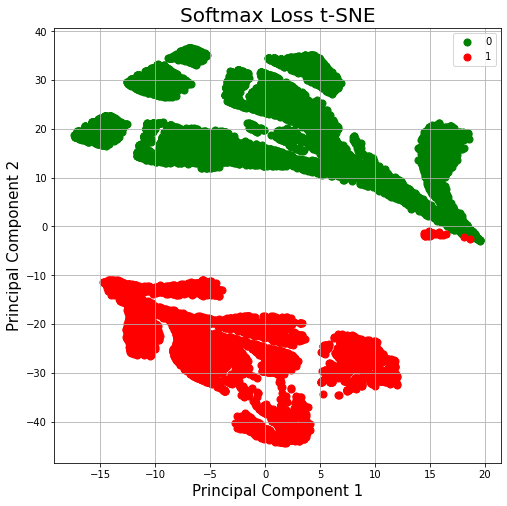

In [32]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Softmax Loss t-SNE', fontsize = 20)
targets = [0, 1]
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['churn'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

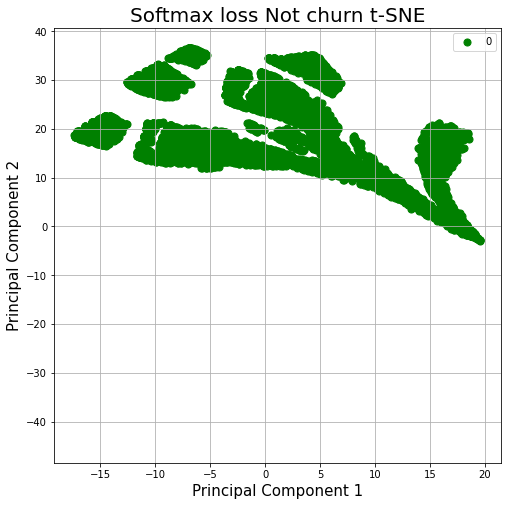

In [33]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Softmax loss Not churn t-SNE', fontsize = 20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
targets = [0]
colors = ['g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf0['churn'] == target
    ax.scatter(finalDf0.loc[indicesToKeep, 'principal component 1']
               , finalDf0.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

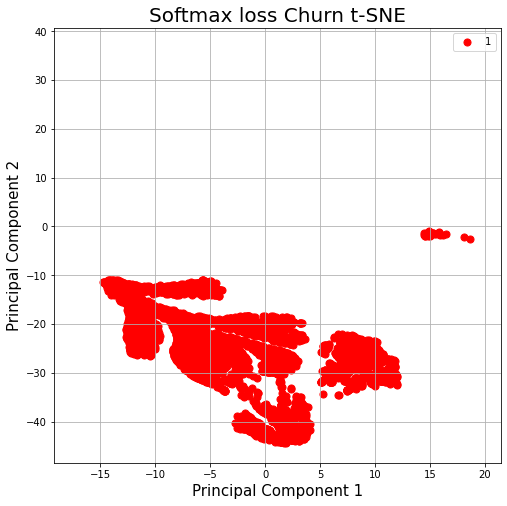

In [34]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Softmax loss Churn t-SNE', fontsize = 20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
targets = [1]
colors = ['r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf1['churn'] == target
    ax.scatter(finalDf1.loc[indicesToKeep, 'principal component 1']
               , finalDf1.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()